In [1]:
import os
from utils.configuration import *
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

In [2]:
experiment_name = "api_ordinal_wine_example"      ## <--- set experiment name
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"  ## <--- set log directory
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

In [3]:
setup_configuration(experiment_name,EXPERIMENT_DIR)

Configuration already exists/home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/configuration.json


In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine

wine = load_wine()
df = pd.DataFrame(wine['data'], columns=wine['feature_names'])
df['target'] = wine['target']

# simulate 1000 samples using Gaussian noise proportional to feature std
X = df.drop(columns='target').values
y = df['target'].values

n_new = 1000 - len(df)
noise_scale = 0.05  # adjust for realism
X_new = []

for _ in range(n_new):
    i = np.random.randint(0, len(X))
    sample = X[i] + np.random.normal(0, noise_scale * X.std(axis=0), X.shape[1])
    X_new.append(sample)

X_new = np.vstack(X_new)
y_new = np.random.choice(y, size=n_new, replace=True)

df_new = pd.DataFrame(X_new, columns=wine['feature_names'])
df_new['target'] = y_new

df_simulated = pd.concat([df, df_new], ignore_index=True)
print(df_simulated.shape)
df_simulated.head()
df=df_simulated

(1000, 14)


In [5]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [6]:
train_df.to_csv(os.path.join(EXPERIMENT_DIR,"train.csv"), index=False)
val_df.to_csv(os.path.join(EXPERIMENT_DIR,"val.csv"), index=False)
test_df.to_csv(os.path.join(EXPERIMENT_DIR,"test.csv"), index=False)

In [7]:
data_type={key:value for key, value in zip(train_df.columns, ['continous']*13+['ordinal_Xc_Yo'])}
data_type

{'alcohol': 'continous',
 'malic_acid': 'continous',
 'ash': 'continous',
 'alcalinity_of_ash': 'continous',
 'magnesium': 'continous',
 'total_phenols': 'continous',
 'flavanoids': 'continous',
 'nonflavanoid_phenols': 'continous',
 'proanthocyanins': 'continous',
 'color_intensity': 'continous',
 'hue': 'continous',
 'od280/od315_of_diluted_wines': 'continous',
 'proline': 'continous',
 'target': 'ordinal_Xc_Yo'}

In [8]:
write_data_type_to_configuration(data_type, CONF_DICT_PATH)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
alcohol              | continous       | continuous [c]                 | continuous [c]                
malic_acid           | continous       | continuous [c]                 | continuous [c]                
ash                  | continous       | continuous [c]                 | continuous [c]                
alcalinity_of_ash    | continous       | continuous [c]                 | continuous [c]                
magnesium            | continous       | continuous [c]                 | continuous [c]                
total_phenols        | continous       | continuous [c]  

/home/bule/TramDag/utils/configuration.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


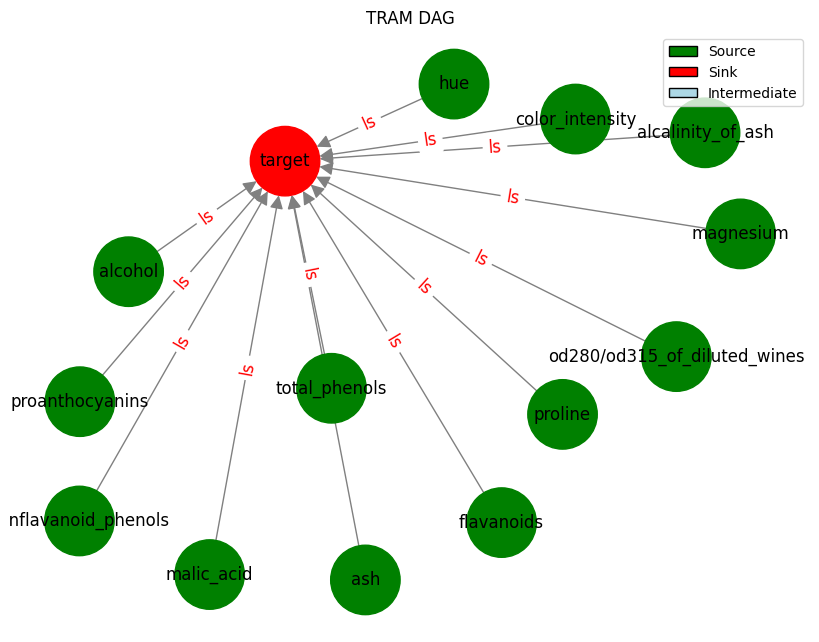

In [9]:
interactive_adj_matrix(CONF_DICT_PATH,seed=19)

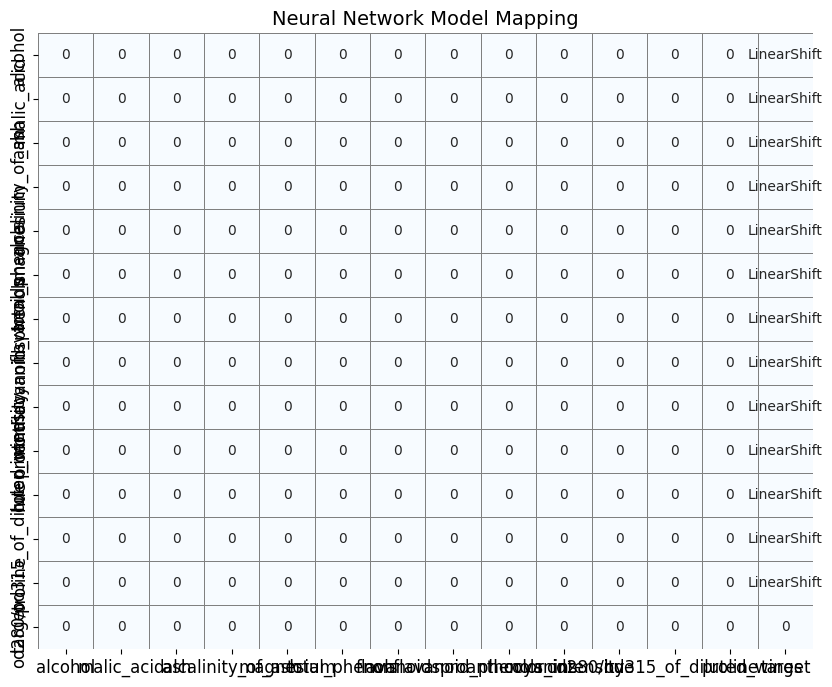

In [10]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [11]:
from utils.tramdag import TramDagConfig , TramDagModel

cfg = TramDagConfig.load("/home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/configuration.json")
cfg.compute_levels(train_df)
device='cpu'

In [12]:
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=True,device=device,initial_data = train_df) 
# 1m52s

[DEBUG] TramDagModel using device: cpu

[INFO] Building model for node 'alcohol' with settings: {'set_initial_weights': False, 'debug': True, 'verbose': True, 'device': 'cpu', 'initial_data':        alcohol  malic_acid       ash  alcalinity_of_ash   magnesium  \
29   14.020000    1.680000  2.210000          16.000000   96.000000   
535  13.819020    1.955278  2.363065          16.695830  101.695757   
695  14.264267    1.716599  2.702250          25.110074   98.504766   
557  12.255680    4.768531  2.533549          20.855062   89.204026   
836  14.681943    1.769885  2.395762          11.246907   90.606691   
..         ...         ...       ...                ...         ...   
106  12.250000    1.730000  2.120000          19.000000   80.000000   
270  12.778080    3.492338  1.956211          16.056776   79.396484   
860  13.333639    2.524270  2.352245          19.917518   88.453177   
435  13.338851    3.163053  2.398598          21.282203   91.729930   
102  12.340000    2.450000 

In [13]:
td_model.fit(train_df, val_df,
            #  train_list=['target'],
             learning_rate=1e-3,
             epochs=100,batch_size=10,
             save_linear_shifts=True,
             verbose=True,debug=False,
             device=device,
             num_workers = 8,
             persistent_workers = True,
             prefetch_factor = 8,
             train_mode = "sequential")#,

#30 eps 1m 49s seq mode from start 1000 bs
#30 eps 2m 27s parllel multiprocessing mode from start 1000 bs
# 200 eps 9m 30s seq mode from start 1000 bs

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/min_max_scaling.json
[INFO] Training 14 nodes (sequential) on cpu

[INFO] Training node 'alcohol' for 100 epochs on cpu (pid=557758)
[INFO] No existing model found. Starting fresh...

===== Epoch 1/100 =====


[INFO] Saved new best model.
[INFO] Epoch 1: Train NLL=2.7637 | Val NLL=2.7439 | Time=0.89s

===== Epoch 2/100 =====
[INFO] Saved new best model.
[INFO] Epoch 2: Train NLL=2.7165 | Val NLL=2.6966 | Time=0.37s

===== Epoch 3/100 =====
[INFO] Saved new best model.
[INFO] Epoch 3: Train NLL=2.6708 | Val NLL=2.6508 | Time=0.38s

===== Epoch 4/100 =====
[INFO] Saved new best model.
[INFO] Epoch 4: Train NLL=2.6264 | Val NLL=2.6063 | Time=0.36s

===== Epoch 5/100 =====
[INFO] Saved new best model.
[INFO] Epoch 5: Train NLL=2.5833 | Val NLL=2.5630 | Time=0.37s

===== Epoch 6/100 =====
[INFO] Saved new best model.
[INFO] Epoch 6: Train NLL=2.5416 | Val NLL=2.5213 | Time=0.37s

===== Epoch 7/100 =====
[INFO] Saved new best model.
[INFO] Epoch 7: Train NLL=2.5012 | Val NLL=2.4808 | Time=0.40s

===== Epoch 8/100 =====
[INFO] Saved new best model.
[INFO] Epoch 8: Train NLL=2.4620 | Val NLL=2.4415 | Time=0.42s

===== Epoch 9/100 =====
[INFO] Saved new best model.
[INFO] Epoch 9: Train NLL=2.4241 | 

In [22]:
linear_shift=td_model.linear_shift_history()

[WARNING] No linear shift history found for node 'alcohol' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/alcohol/linear_shifts_all_epochs.json
[WARNING] No linear shift history found for node 'malic_acid' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/malic_acid/linear_shifts_all_epochs.json
[WARNING] No linear shift history found for node 'ash' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/ash/linear_shifts_all_epochs.json
[WARNING] No linear shift history found for node 'alcalinity_of_ash' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/alcalinity_of_ash/linear_shifts_all_epochs.json
[WARNING] No linear shift history found for node 'magnesium' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/magnesium/linear_shifts_all_epochs.json
[WARNING] No linear shift history found for node 'total_phenols' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/total_phenols/linear_shift

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_shift_histories(data_dict, node='target'):
    """
    Plot the evolution of shift terms across epochs for a given node (e.g., 'target').

    Args:
        data_dict (dict): Dictionary where keys are node names (e.g., 'target')
                          and values are DataFrames with epochs as columns and shifts as rows.
        node (str): Node name to plot (default='target')
    """
    df = data_dict[node].copy()

    # Flatten nested lists in DataFrame cells
    df = df.applymap(lambda x: x[0][0] if isinstance(x, list) and isinstance(x[0], list) else x)

    # Convert column names to integers if possible
    df.columns = [int(c.replace('epoch_', '')) if isinstance(c, str) and c.startswith('epoch_') else c for c in df.columns]

    # Sort by epoch
    df = df.reindex(sorted(df.columns), axis=1)

    # Plot each shift
    plt.figure(figsize=(10, 6))
    for shift in df.index:
        plt.plot(df.columns, df.loc[shift], label=shift)

    plt.xlabel('Epoch')
    plt.ylabel('Shift value')
    plt.title(f'Shift term history for node: {node}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [16]:
linear_shift

{'target':                             epoch_1                    epoch_2  \
 shift_0    [[-0.20814335346221902]]   [[-0.20814335346221902]]   
 shift_1       [[0.035449981689453]]      [[0.035449981689453]]   
 shift_2       [[0.310384631156921]]      [[0.310384631156921]]   
 shift_3       [[0.130940437316894]]      [[0.130940437316894]]   
 shift_4     [[-0.9166908264160151]]    [[-0.9166908264160151]]   
 shift_5    [[-0.47186815738677906]]   [[-0.47186815738677906]]   
 shift_6        [[0.62734055519104]]       [[0.62734055519104]]   
 shift_7       [[0.776865601539611]]      [[0.776865601539611]]   
 shift_8      [[0.9690299034118651]]     [[0.9690299034118651]]   
 shift_9   [[-0.038082718849182004]]  [[-0.038082718849182004]]   
 shift_10   [[-0.44645059108734103]]   [[-0.44645059108734103]]   
 shift_11      [[0.995632648468017]]      [[0.995632648468017]]   
 shift_12    [[-0.9984405040740961]]    [[-0.9984405040740961]]   
 
                             epoch_3              

In [17]:
rsamples, latents = td_model.sample()

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Deleting all previously sampled data.
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/alcohol/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/malic_acid/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/ash/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/alcalinity_of_ash/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/magnesium/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/total_phenols/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/flavanoids/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/nonflavanoid_phenols/sampling
Dir

[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 45.71it/s]

[INFO] Completed sampling for node 'alcohol'

----*----------*-------------*--------Sample Node: malic_acid ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node malic_acid from standard logistic distribution
[WARNING] target_col 'malic_acid' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 43.81it/s]

[INFO] Completed sampling for node 'malic_acid'

----*----------*-------------*--------Sample Node: ash ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node ash from standard logistic distribution
[WARNING] target_col 'ash' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 44.53it/s]

[INFO] Completed sampling for node 'ash'

----*----------*-------------*--------Sample Node: alcalinity_of_ash ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node alcalinity_of_ash from standard logistic distribution
[WARNING] target_col 'alcalinity_of_ash' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 43.70it/s]

[INFO] Completed sampling for node 'alcalinity_of_ash'

----*----------*-------------*--------Sample Node: magnesium ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node magnesium from standard logistic distribution
[WARNING] target_col 'magnesium' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 45.92it/s]

[INFO] Completed sampling for node 'magnesium'

----*----------*-------------*--------Sample Node: total_phenols ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node total_phenols from standard logistic distribution
[WARNING] target_col 'total_phenols' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 44.20it/s]

[INFO] Completed sampling for node 'total_phenols'

----*----------*-------------*--------Sample Node: flavanoids ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node flavanoids from standard logistic distribution
[WARNING] target_col 'flavanoids' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 43.69it/s]

[INFO] Completed sampling for node 'flavanoids'

----*----------*-------------*--------Sample Node: nonflavanoid_phenols ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node nonflavanoid_phenols from standard logistic distribution
[WARNING] target_col 'nonflavanoid_phenols' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 47.07it/s]

[INFO] Completed sampling for node 'nonflavanoid_phenols'

----*----------*-------------*--------Sample Node: proanthocyanins ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node proanthocyanins from standard logistic distribution
[WARNING] target_col 'proanthocyanins' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 44.27it/s]


[INFO] Completed sampling for node 'proanthocyanins'

----*----------*-------------*--------Sample Node: color_intensity ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node color_intensity from standard logistic distribution
[WARNING] target_col 'color_intensity' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 45.49it/s]

[INFO] Completed sampling for node 'color_intensity'

----*----------*-------------*--------Sample Node: hue ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node hue from standard logistic distribution
[WARNING] target_col 'hue' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 44.52it/s]

[INFO] Completed sampling for node 'hue'

----*----------*-------------*--------Sample Node: od280/od315_of_diluted_wines ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node od280/od315_of_diluted_wines from standard logistic distribution
[WARNING] target_col 'od280/od315_of_diluted_wines' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 47.22it/s]

[INFO] Completed sampling for node 'od280/od315_of_diluted_wines'

----*----------*-------------*--------Sample Node: proline ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node proline from standard logistic distribution
[WARNING] target_col 'proline' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 47.34it/s]

[INFO] Completed sampling for node 'proline'

----*----------*-------------*--------Sample Node: target ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node target from standard logistic distribution
[WARNING] target_col 'target' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Completed sampling for node 'target'
[INFO] DAG sampling completed successfully for all nodes.


/tmp/ipykernel_557758/768650124.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x[0][0] if isinstance(x, list) and isinstance(x[0], list) else x)


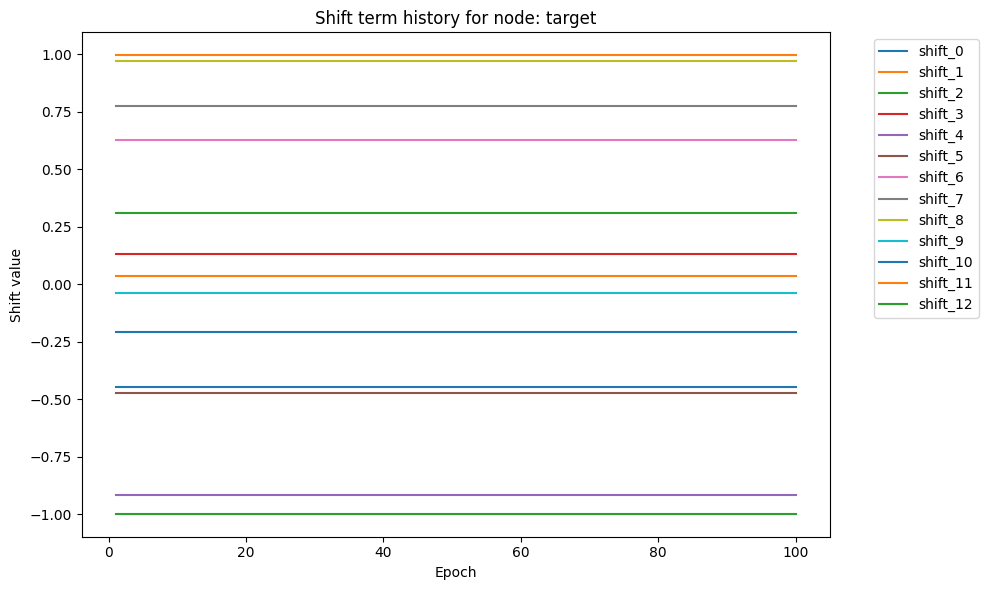

In [23]:
plot_shift_histories(linear_shift)


[INFO] Loaded training/validation histories for 14 nodes.


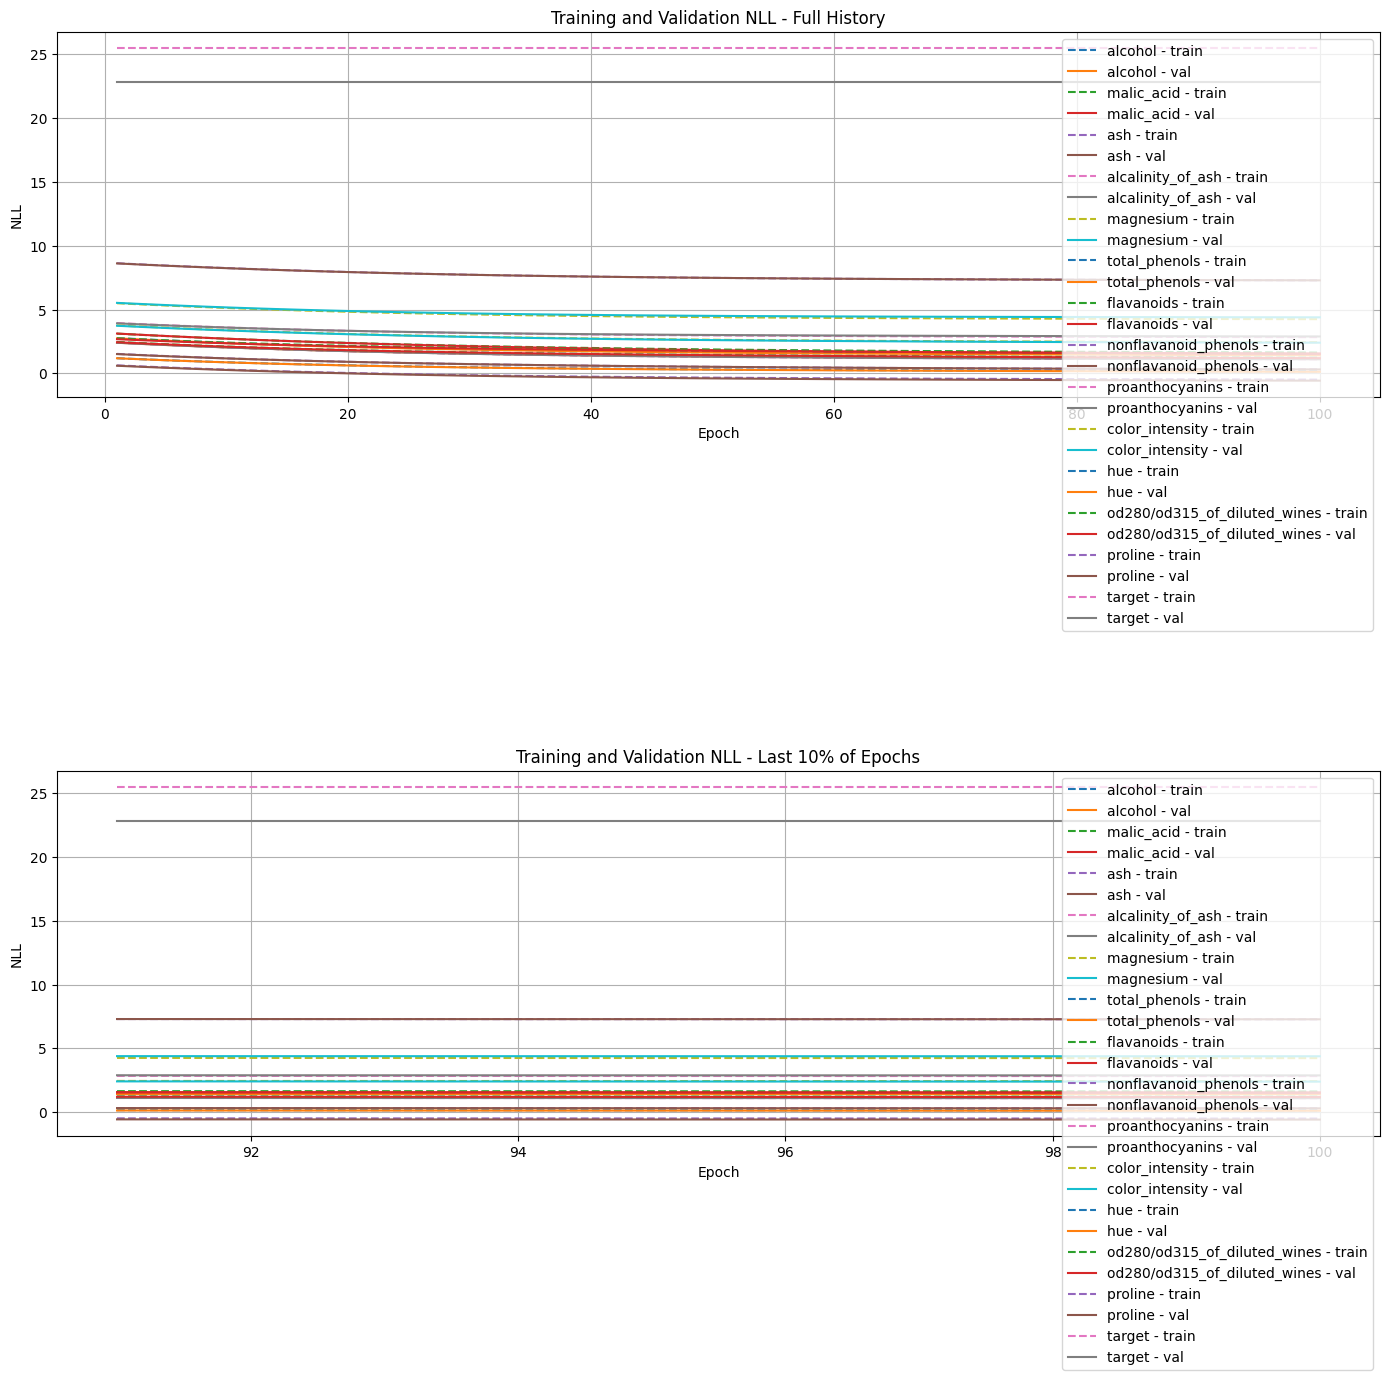

In [25]:
td_model.plot_history()

In [20]:
# x1-> x2, x1-> x3, x2-> x3
true_coeffs = {'x2': [2],'x3': [-0.2, 0.3]}

for node in conf_dict:
    print(f'\n----*----------*-------------*--------check LS of {node} ------------*-----------------*-------------------*--')
    
    if conf_dict[node]['node_type'] == 'source':
        print(f"Node type :source")
        continue
    
    # Paths
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    # Load saved shifts
    shift_path = os.path.join(NODE_DIR, "linear_shifts_all_epochs.json")
    with open(shift_path, 'r') as f:
        all_shift_weights = json.load(f)

    # Sort epochs numerically
    epochs = sorted(all_shift_weights.keys(), key=lambda x: int(x.split('_')[1]))

    # Number of shifts (incoming edges) for this node
    example_epoch = all_shift_weights[epochs[0]]
    num_shifts = len(example_epoch)

    # Plot per shift (incoming edge)
    for shifts_idx in range(num_shifts):
        
        if node=='x3':
            shift_name = f"shift_{1}"
        else:
            shift_name = f"shift_{shifts_idx}"
        weights_over_time = []

        for epoch in epochs:
            weight_matrix = np.array(all_shift_weights[epoch][shift_name])  # shape: [out_features, in_features]
            avg_weight = weight_matrix.mean()
            weights_over_time.append(avg_weight)

        plt.figure()
        plt.plot(range(1, len(epochs) + 1), weights_over_time)

        # If this node has a true coefficient for this shift, draw a horizontal red line
        if node in true_coeffs:
            true_val = true_coeffs[node][shifts_idx]
            plt.axhline(y=true_val, color='r', linestyle='--', label=f"True coeff = {true_val}")
            plt.legend()

        plt.title(f"Linear Shift Weights in h({node}), ")
        plt.xlabel("Epoch")
        plt.ylabel(fr'$\hat{{\beta}}_{{{conf_dict[node]["parents"][shifts_idx]}}}$')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

NameError: name 'conf_dict' is not defined

In [ ]:
td_model.show_samples_vs_true(train_df)